In [ ]:
%load_ext autoreload
%autoreload 2

import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import datetime
import collections

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

sys.path.append(os.path.join(sys.path[0], '../'))


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
events_data  = pd.read_csv(f"../event_data_train.csv")
submissions_data = pd.read_csv(f"../submissions_data_train.csv")

DATA_PERIOD_DAYS = 2

In [ ]:
def preprocess_timestamp_cols(data):
    """ 
    Parameters
    ----------
    data : pd.DataFrame
        данные с действиями пользователя
    """
    data['date'] = pd.to_datetime(data.timestamp, unit='s')
    data['day'] = data.date.dt.date
    return data

In [ ]:
def truncate_data_by_nday(data, n_day):
    """ Взять события из n_day первых дней по каждому пользователю 
        Parameters
        ----------
        data: pandas.DataFrame
            действия студентов со степами или практикой
        n_day : int
            размер тестовой выборки
    """
    users_min_time = data.groupby('user_id', as_index=False).agg({'timestamp': 'min'}).rename(
        {'timestamp': 'min_timestamp'}, axis=1)
    users_min_time['min_timestamp'] += 60 * 60 * 24 * n_day

    events_data_d = pd.merge(data, users_min_time, how='inner', on='user_id')
    cond = events_data_d['timestamp'] <= events_data_d['min_timestamp']
    events_data_d = events_data_d[cond]

    assert events_data_d.user_id.nunique() == data.user_id.nunique()
    return events_data_d.drop(['min_timestamp'], axis=1)

In [ ]:
def create_user_data(events, submissions):
    """ создать таблицу с данными по каждому пользователю
    Parameters
    ----------
    events : pd.DataFrame
        данные с действиями пользователя
    submissions : pd.DataFrame
        данные самбитов практики
    """
    users_data = events.groupby('user_id', as_index=False) \
        .agg({'timestamp': 'max'}).rename(columns={'timestamp': 'last_timestamp'})

    # попытки сдачи практики пользователя
    users_scores = submissions.pivot_table(index='user_id',
                                           columns='submission_status',
                                           values='step_id',
                                           aggfunc='count',
                                           fill_value=0).reset_index()
    users_data = users_data.merge(users_scores, on='user_id', how='outer')
    users_data = users_data.fillna(0)

    # колво разных событий пользователя по урокам
    users_events_data = events.pivot_table(index='user_id',
                                           columns='action',
                                           values='step_id',
                                           aggfunc='count',
                                           fill_value=0).reset_index()
    users_data = users_data.merge(users_events_data, how='outer')

    # колво дней на курсе
    users_days = events.groupby('user_id').day.nunique().to_frame().reset_index()
    users_data = users_data.merge(users_days, how='outer')

    return users_data

In [ ]:
def create_interaction(events, submissions):
    """ объединить все данные по взаимодействию
    Parameters
    ----------
    events : pd.DataFrame
        данные с действиями пользователя
    submissions : pd.DataFrame
        данные самбитов практики
    """
    interact_train = pd.concat([events, submissions.rename(columns={'submission_status': 'action'})])
    interact_train.action = pd.Categorical(interact_train.action,
                                           ['discovered', 'viewed', 'started_attempt',
                                            'wrong', 'passed', 'correct'], ordered=True)
    interact_train = interact_train.sort_values(['user_id', 'timestamp', 'action'])
    return interact_train

In [ ]:
def get_label(events, submissions, course_threshold=40, target_action='correct'):
    """ создать метку  (целевая переменная для прогноза is_gone
    Parameters
    ----------
    events : pd.DataFrame
        данные с действиями пользователя
    submissions : pd.DataFrame
        данные самбитов практики
    course_threshold : int
        порог в колве заданий, когда курс считается пройденным
    target_action: string
        название действия по степу, по колву которых мы рассчитываем целевую переменную 
    """
    interactions = create_interaction(events, submissions)
    users_data = interactions[['user_id']].drop_duplicates()

    assert target_action in interactions.action.unique()

    # вместо count по хорошему нужно брать уникальные степы. Потому что correct может встречаться более 1 раза
    passed_steps = (interactions.query("action == @target_action")
                    .groupby('user_id', as_index=False)['step_id'].agg(lambda a: len(np.unique(a)))
                    .rename(columns={'step_id': target_action}))
    users_data = users_data.merge(passed_steps, how='outer')

    # пройден ли курс
    users_data['is_gone'] = users_data[target_action] > course_threshold
    assert users_data.user_id.nunique() == events.user_id.nunique()
    users_data = (users_data.drop(target_action, axis=1)
                  .set_index('user_id'))
    return users_data['is_gone']

In [ ]:
def safe_drop_cols_df(df, drop_cols):
    """ Удаление столбцов из датафрейма с проверкой на их существование.
    Изменяет переданный датафрейм
    
    Parameters
    ----------
    df: pandas.DataFrame
        датафрейм
    drop_cols: list of string
        Список столбцов которые нужно удалить
    """

    if isinstance(drop_cols, str) or (not isinstance(drop_cols, collections.Iterable)):
        drop_cols = [drop_cols]
    drop_col_names = np.intersect1d(df.columns, drop_cols)
    df.drop(drop_col_names, axis=1, inplace=True)

In [ ]:
def get_labels_metrics(events, submissions):
    """" создадим признаки и метку
     
    Parameters
    ----------
    events: pandas.DataFrame
        действия студентов со степами
    submissions: pandas.DataFrame
        действия студентов по практике     
     """
    events_train = preprocess_timestamp_cols(events)
    events_train = truncate_data_by_nday(events_train, DATA_PERIOD_DAYS)

    submissions_train = preprocess_timestamp_cols(submissions)
    submissions_train = truncate_data_by_nday(submissions_train, DATA_PERIOD_DAYS)

    X = create_user_data(events_train, submissions_train)
    X = X.set_index('user_id')
    safe_drop_cols_df(X, ['last_timestamp'])

    y = get_label(events, submissions, 40, 'correct')

    # после создания признаков и метки порядок следования user_id может не совпадать
    X = X.sort_index()
    y = y.sort_index()
    assert X.shape[0] == y.shape[0]
    return X, y

In [ ]:
X, y = get_labels_metrics(events_data, submissions_data)

In [ ]:
X.shape

In [ ]:
# разделение данных для обучения на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
print ('X_train shape', X_train.shape)
y_train.value_counts(dropna=False)

# ОБУЧЕНИЕ

In [39]:
# METHOD 1
# clf_rf = RandomForestClassifier(n_estimators=100, n_jobs=2, 
#                             min_samples_leaf=10, min_samples_split=10, 
#                             class_weight='balanced')

# clf_rf.fit(X_train, y_train)
# pred_proba = clf_rf.predict_proba(X_test)
# roc_score = roc_auc_score(y_test, pred_proba[:, 1])
# print('roc на test', roc_score)

RandomForestClassifier(class_weight='balanced', min_samples_leaf=10,
                       min_samples_split=10, n_jobs=2)

roc на test 0.8840243697074673


In [ ]:
#METHOD 2
from sklearn.model_selection import GridSearchCV

clf_rf = RandomForestClassifier()z
parametrs = {'n_estimators': range(10, 80, 10), 'max_depth': range(1, 13, 2), 
             'min_samples_leaf': range(1, 11), 'min_samples_split': range(2, 13, 2)}

grid_search_cv_clf = GridSearchCV(clf_rf, parametrs, cv=3, n_jobs=-1)

grid_search_cv_clf.fit(X_train, y_train)
grid_search_cv_clf.best_params_

best_clf = grid_search_cv_clf.best_estimator_

pred_proba = best_clf.predict_proba(X_test)
roc_score = roc_auc_score(y_test, pred_proba[:, 1])
print('roc на test', roc_score)

In [ ]:
# METHOD 3
# research n_estimators
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier


num_trees = np.arange(1, 200, 10)
num_features = np.arange(1, X.shape[1]+1, 1)
depths = np.arange(1, 100, 5)

a = []
nn = 0
for i in num_trees:
    nn += 1
    print(nn)
    temp_tree = DecisionTreeClassifier(splitter='best')
    temp_model = BaggingClassifier(temp_tree, n_estimators=i)
    temp_score = cross_val_score(temp_model, X, y, cv=10)
    a.append(np.mean(temp_score))

plt.plot(num_trees, a)
plt.xlabel("num_trees")
plt.ylabel("Score")


In [ ]:
# research max_features
a = []
nn = 0
for i in num_features:
    nn += 1
    print(nn)
    temp_tree = DecisionTreeClassifier(splitter='best', max_features=i)
    temp_model = BaggingClassifier(temp_tree, max_features=i)
    temp_score = cross_val_score(temp_model, X, y, cv=10)
    a.append(np.mean(temp_score))
    
plt.plot(num_features, a[num_trees.shape[0]:])
plt.xlabel("num_features")
plt.ylabel("Score")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


Text(0.5, 0, 'depth')

Text(0, 0.5, 'Score')

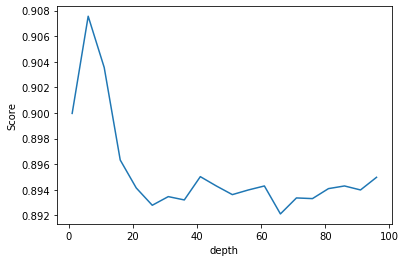

In [85]:
nn = 0
b = []
for i in depths:
    nn += 1
    print(nn)
    temp_tree = DecisionTreeClassifier(splitter='best', max_depth=i)
    temp_model = BaggingClassifier(temp_tree)
    temp_score = cross_val_score(temp_model, X, y, cv=10)
    b.append(np.mean(temp_score))
    
plt.plot(depths, b)
plt.xlabel("depth")
plt.ylabel("Score")

In [186]:
clf_random = DecisionTreeClassifier(max_features=1, max_depth=8)
bag_model2 = BaggingClassifier(clf_random, n_estimators=155)

In [187]:
bag_model2.fit(X_train, y_train)
pred_proba = bag_model2.predict_proba(X_test)
roc_score = roc_auc_score(y_test, pred_proba[:, 1])
print('roc на test', roc_score)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=8,
                                                        max_features=1),
                  bootstrap=False, n_estimators=155)

roc на test 0.8840920299268668


correct             3.649007
wrong               3.349641
discovered         12.364875
passed             11.407040
started_attempt     4.109754
viewed             19.232973
day                 1.343038
dtype: float64

In [180]:
# METHOD 4
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
transform = PolynomialFeatures(2)
scaler = StandardScaler()
X_train_real_scaled = scaler.fit_transform(X_train)
X_test_real_scaled = scaler.transform(X_test)

estimator = LogisticRegression(class_weight='balanced', fit_intercept=False)
optimizer = GridSearchCV(estimator, param_grid, scoring='roc_auc', cv=10)
optimizer.fit(X_train_real_scaled, y_train)
Z = optimizer.predict_proba(X_test_real_scaled)[:, 1]
roc = roc_auc_score(y_test, Z)

GridSearchCV(cv=10,
             estimator=LogisticRegression(class_weight='balanced',
                                          fit_intercept=False),
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]})

In [181]:
print(roc)
estimator = optimizer.best_estimator_
estimator.coef_

0.8800444452463434


array([[ 1.33441512, -0.1690829 , -0.5361754 ,  0.87260755, -0.18702058,
        -0.07809031,  0.18057301]])

In [42]:
# METHOD 5
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
def xgb_classifier(X_train, X_test, y_train, y_test, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    """
    """
#     alg = XGBClassifier(learning_rate=0.1, n_estimators=175, max_depth=8,
#                         min_child_weight=2, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
#                         objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

    if useTrainCV:
        print("Start Feeding Data")
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train.values, label=y_train.values)
        # xgtest = xgb.DMatrix(X_test.values, label=y_test.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])

#     print('Start Training')
#     alg.fit(X_train, y_train, eval_metric='auc')

    param_test1 = {'n_estimators': range(10, 80, 10), 'max_depth': range(1, 13, 2), 'min_child_weight':range(1, 11)}
    gsearch1 = GridSearchCV(estimator=XGBClassifier(),
                                                    param_grid=param_test1,
                                                    n_jobs=4, iid=False, cv=3)
    gsearch1.fit(X_train, y_train)
    print(gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_)
    return gsearch1
#     print("Start Predicting")
#     predictions = alg.predict(X_test)
#     return alg.predict_proba(X_test)[:, 1]

In [ ]:
alg = xgb_classifier(X_train, X_test, y_train, y_test, useTrainCV=False)

In [47]:
# pred_proba = alg.predict_proba(X_test)
# roc_score = roc_auc_score(y_test, pred_proba[:, 1])
# print('roc на test', roc_score)

best_clf = alg.best_estimator_
best_clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=8, missing=nan, monotone_constraints='()',
              n_estimators=110, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [48]:
pred_proba = best_clf.predict_proba(X_test)
roc_score = roc_auc_score(y_test, pred_proba[:, 1])
print('roc на test', roc_score)

roc на test 0.8787228156274056


In [42]:
fimp = get_feature_importances_df(clf_rf.feature_importances_, X_train.columns)
fimp.head(15)

,weight
correct,0.390768
wrong,0.143564
passed,0.130937
started_attempt,0.124924
discovered,0.107269
viewed,0.087266
day,0.015271


In [92]:
# значение к метрике на кроссвалидации коррелирует к метрике на степике

rfcv = RandomForestClassifier(**best_clf.get_params())

cv_scores = cross_val_score(rfcv, X, y, scoring='roc_auc', cv=10, n_jobs=-1)
mean_cv_scores = np.mean(cv_scores)
print ('mean score', mean_cv_scores)

TypeError: __init__() got an unexpected keyword argument 'presort'

In [45]:
def create_report(user_ids, preds):
    res = pd.DataFrame(preds[:, np.newaxis], columns=['is_gone'], index=user_ids)
    return res.reset_index()


def save_report(rep, submit_num=None):
    submit_str = ""
    if submit_num:
        submit_str = f"_submit_{submit_num}"
    fname = f"predict_{datetime.datetime.now():%Y-%m-%d}{submit_str}.csv"
    rep.to_csv(fname, index=False)
    return fname

In [185]:
SUBMIT_NUM = 2

events_pred  = pd.read_csv(f"../events_data_test.csv")
submissions_pred = pd.read_csv(f"../submission_data_test.csv")
X_pred , _ = get_labels_metrics(events_pred, submissions_pred)

pred_proba = bag_model2.predict_proba(X_pred)[:, 1]
rep_df = create_report(X_pred.index, pred_proba)
assert rep_df.user_id.nunique() == X_pred.index.nunique()
print ('Прогноз сохранен в файл ', save_report(rep_df, SUBMIT_NUM))

print ('Распределение "вероятностей" модели')
pd.cut(pred_proba, 10).value_counts()

Прогноз сохранен в файл  predict_2020-11-23_submit_2.csv
Распределение "вероятностей" модели


(-0.000527, 0.0815]    4042
(0.0815, 0.163]        1033
(0.163, 0.244]          334
(0.244, 0.325]          197
(0.325, 0.406]          203
(0.406, 0.488]          203
(0.488, 0.569]           93
(0.569, 0.65]            34
(0.65, 0.731]            32
(0.731, 0.812]           13
dtype: int64